# Project

The purpose of this project is to predict the selling price of the car based on following kaggle dataset:
https://www.kaggle.com/nehalbirla/vehicle-dataset-from-cardekho

# Dataset Description

This kaggle dataset contains information about used cars listed on www.cardekho.com. 
The columns in the given dataset is as follows:
- Car_Name - name of the car
- Year - year in which the car was bought
- Selling_Price - price at which the car is being sold
- Present_Price - current ex-showroom price of the car
- Kms_Driven - distance completed by the car in km
- Fuel_Type - fuel type of the car
- Seller_Type - whether the seller is a dealer or an individual
- Transmission - whether the car is manual or automatic
- Owner - the number of owners the car has previously had

# Project Outline

- Data Exploration: Check for null values, identify unique values of categorical features and one hot encoding of all categorical feature, analyze correlation b/w features, identify feature importance using ExtraTreeRegressor
- Data Preparation: Add 'Car Age' feature using current year and car purchase year. 20-80 test-train split
- Sklearn Pipeline: Setting up sklearn pipeline to perform scaling and model fitting in ridge and lasso and perform hyperparameter tuning on these pipelines
- Model: RandomizedSearchCV with 5-fold cross-validation to search the  best model and corresponding best parameters among all the trained models and provided hyperparameter values
- Ridge Regression turns out to be best among all trained models

# Importing Required Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

# Data Exploration

In [2]:
df = pd.read_csv("car data.csv")
df.head()

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


In [3]:
#check missing values in data
df.isnull().sum()
#No missing values in the data

Car_Name         0
Year             0
Selling_Price    0
Present_Price    0
Kms_Driven       0
Fuel_Type        0
Seller_Type      0
Transmission     0
Owner            0
dtype: int64

In [4]:
#unique values of categorical features
print(df['Seller_Type'].unique())
print(df['Fuel_Type'].unique())
print(df['Transmission'].unique())

['Dealer' 'Individual']
['Petrol' 'Diesel' 'CNG']
['Manual' 'Automatic']


In [5]:
df.describe()

,Year,Selling_Price,Present_Price,Kms_Driven,Owner
count,301.000000,301.000000,301.000000,301.000000,301.000000
mean,2013.627907,4.661296,7.628472,36947.205980,0.043189
std,2.891554,5.082812,8.644115,38886.883882,0.247915
min,2003.000000,0.100000,0.320000,500.000000,0.000000
25%,2012.000000,0.900000,1.200000,15000.000000,0.000000
50%,2014.000000,3.600000,6.400000,32000.000000,0.000000
75%,2016.000000,6.000000,9.900000,48767.000000,0.000000
max,2018.000000,35.000000,92.600000,500000.000000,3.000000


In [6]:
features = list(df.columns)
df_final = df[features[1:]]
df_final['Current Year'] = 2021
#add column to determine age of car
df_final['Car Age'] = df_final['Current Year'] - df_final['Year']
df_final.drop(['Year','Current Year'],axis = 1,inplace = True)
#one hot encoding of categorical features
df_final = pd.get_dummies(df_final,drop_first=True)
df_final.head()

,Selling_Price,Present_Price,Kms_Driven,Owner,Car Age,Fuel_Type_Diesel,Fuel_Type_Petrol,Seller_Type_Individual,Transmission_Manual
0,3.35,5.59,27000,0,7,0,1,0,1
1,4.75,9.54,43000,0,8,1,0,0,1
2,7.25,9.85,6900,0,4,0,1,0,1
3,2.85,4.15,5200,0,10,0,1,0,1
4,4.60,6.87,42450,0,7,1,0,0,1


In [7]:
#check correlation b/w different attributes
df_final.corr()

,Selling_Price,Present_Price,Kms_Driven,Owner,Car Age,Fuel_Type_Diesel,Fuel_Type_Petrol,Seller_Type_Individual,Transmission_Manual
Selling_Price,1.000000,0.878983,0.029187,-0.088344,-0.236141,0.552339,-0.540571,-0.550724,-0.367128
Present_Price,0.878983,1.000000,0.203647,0.008057,0.047584,0.473306,-0.465244,-0.512030,-0.348715
Kms_Driven,0.029187,0.203647,1.000000,0.089216,0.524342,0.172515,-0.172874,-0.101419,-0.162510
Owner,-0.088344,0.008057,0.089216,1.000000,0.182104,-0.053469,0.055687,0.124269,-0.050316
Car Age,-0.236141,0.047584,0.524342,0.182104,1.000000,-0.064315,0.059959,0.039896,-0.000394
Fuel_Type_Diesel,0.552339,0.473306,0.172515,-0.053469,-0.064315,1.000000,-0.979648,-0.350467,-0.098643
Fuel_Type_Petrol,-0.540571,-0.465244,-0.172874,0.055687,0.059959,-0.979648,1.000000,0.358321,0.091013
Seller_Type_Individual,-0.550724,-0.512030,-0.101419,0.124269,0.039896,-0.350467,0.358321,1.000000,0.063240
Transmission_Manual,-0.367128,-0.348715,-0.162510,-0.050316,-0.000394,-0.098643,0.091013,0.063240,1.000000


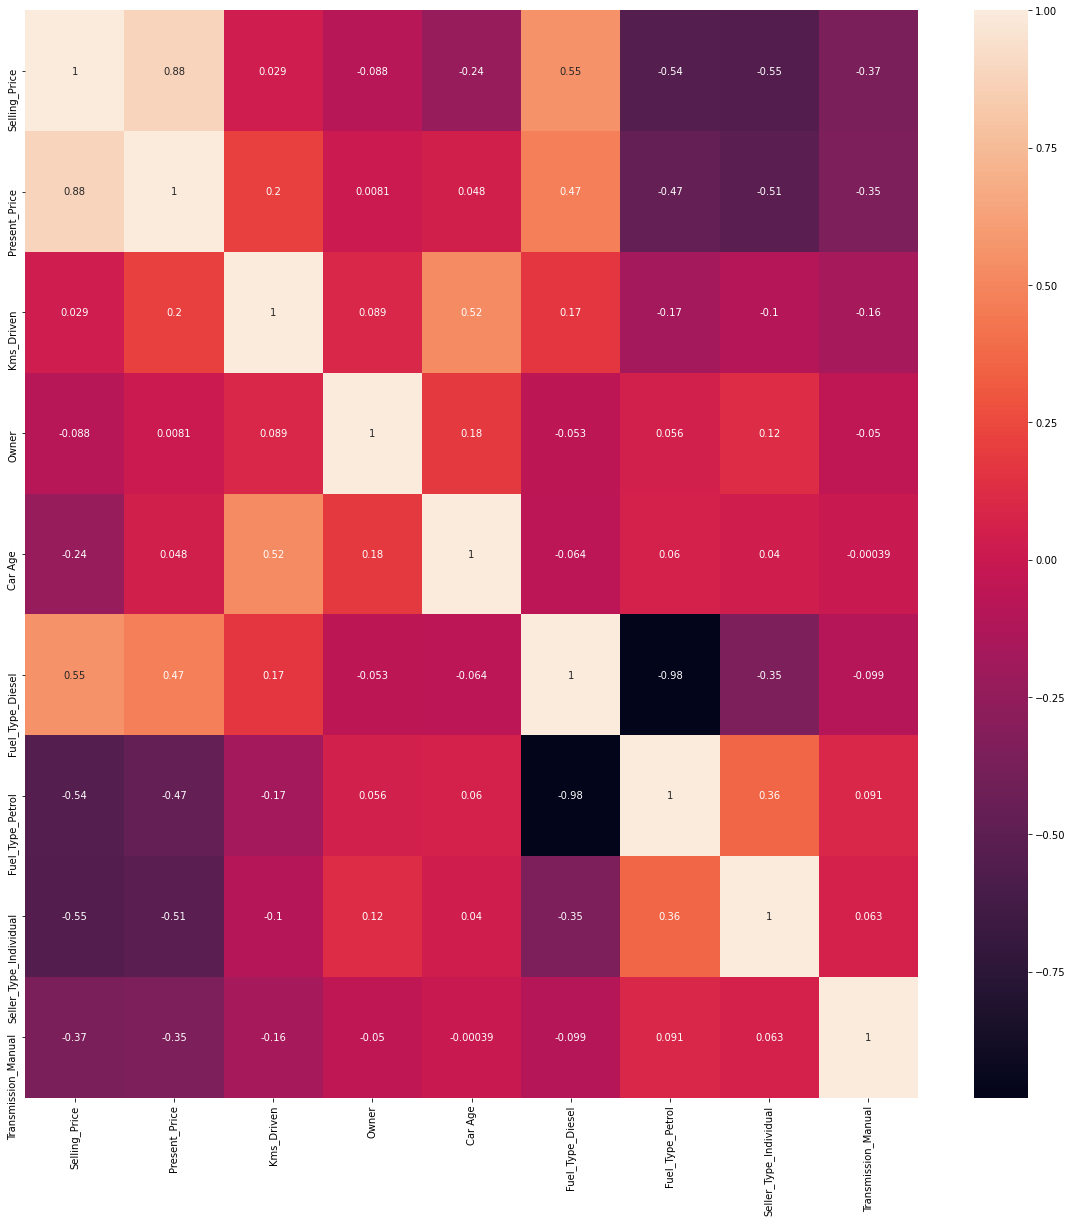

In [8]:
#heatmap indicating correlation b/w different attributes
plt.figure(figsize = (20,20))
hmap = sns.heatmap(df_final.corr(),annot = True)

In [9]:
#convert data into (X,y) format i.e features and target variables
y = df_final['Selling_Price']
X = df_final.drop(['Selling_Price'],axis = 1)

# Feature Importance 

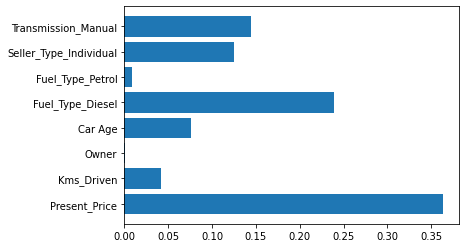

In [10]:
#checking feature importance
model = ExtraTreesRegressor()
model.fit(X,y)
plt.figure()
plt.barh(X.columns,model.feature_importances_)
plt.show()

In [11]:
#top 5 important features
feature_importances = pd.Series(model.feature_importances_,index = X.columns)
top_features = feature_importances.nlargest(5)
top_features

Present_Price             0.363619
Fuel_Type_Diesel          0.239367
Transmission_Manual       0.144456
Seller_Type_Individual    0.125229
Car Age                   0.075502
dtype: float64

# Model

In [12]:
#train test split of data
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2)

In [24]:
#setting up sklearn pipeline to perform scaling and model fitting in ridge and lasso 
#and to perform hyperparameter tuning on these linear, ridge, lasso and random forest regression pipelines
pipe_linear_reg = Pipeline([('reg', LinearRegression())])
#Note that parameter scaling helps in Regularised Regression Algorithms
pipe_ridge = Pipeline([('scl', MinMaxScaler()),('reg', Ridge(random_state=21))])
pipe_lasso = Pipeline([('scl', MinMaxScaler()),('reg', Lasso(random_state=21))])
pipe_rf = Pipeline([('reg', RandomForestRegressor(random_state=21))])

In [25]:
pipe_lasso.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'scl', 'reg', 'scl__clip', 'scl__copy', 'scl__feature_range', 'reg__alpha', 'reg__copy_X', 'reg__fit_intercept', 'reg__max_iter', 'reg__normalize', 'reg__positive', 'reg__precompute', 'reg__random_state', 'reg__selection', 'reg__tol', 'reg__warm_start'])

In [26]:
#hyperparameter tuning (i.e. tune the model to achieve best score by iterating over different values of hyperparameters)
alpha = [0.5,1,2,5,10] #for ridge and lasso
max_iters = [100,1000,5000,10000] #for ridge and lasso
n_estimators = [int(x) for x in np.linspace(100,1000,10)] #for randomforest
max_features = ['auto','sqrt'] #for randomforest
max_depth = [5,10,15,20,25,30] #for randomforest
min_samples_split = [2,5,10,20,50,100] #for randomforest
min_samples_leaf = [1,5,10,20] #for randomforest

In [30]:
grid_params_linear_reg = [{}] 
grid_params_ridge = [{'reg__alpha':alpha,'reg__max_iter':max_iters}]
grid_params_lasso = [{'reg__alpha':alpha,'reg__max_iter':max_iters}]
grid_params_rf = [{'reg__n_estimators':n_estimators,'reg__max_features':max_features,'reg__max_depth':max_depth,'reg__min_samples_split':min_samples_split,'reg__min_samples_leaf':min_samples_leaf}]

In [31]:
# choose appropriate scoring metric
from sklearn.metrics import SCORERS
print(SCORERS.keys())

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

In [50]:
#we will use 'neg_mean_squared_error'
#RandomizedSearchCV to search the  best model and corresponding best parameters among all the trained models and provided hyperparameter values
#using crossvalidation with 5-folds
rs_linear_reg = RandomizedSearchCV(estimator = pipe_linear_reg, param_distributions = grid_params_linear_reg, cv = 5,verbose = 2, n_iter = 10,scoring = 'neg_mean_squared_error',random_state=21)
rs_linear_ridge = RandomizedSearchCV(estimator = pipe_ridge, param_distributions = grid_params_ridge, cv = 5,verbose = 2, n_iter = 10,scoring = 'neg_mean_squared_error',random_state=21)
rs_linear_lasso = RandomizedSearchCV(estimator = pipe_lasso, param_distributions = grid_params_lasso, cv = 5,verbose = 2, n_iter = 10,scoring = 'neg_mean_squared_error',random_state=21)
rs_linear_rf = RandomizedSearchCV(estimator = pipe_rf, param_distributions = grid_params_rf, cv = 5,verbose = 2, n_iter = 10,scoring = 'neg_mean_squared_error',random_state=21)

In [33]:
# List of pipelines
grids = [rs_linear_reg, rs_linear_ridge, rs_linear_lasso, rs_linear_rf]

# Dictionary of pipelines and regressor types
grid_dict = {0: 'Linear Regression', 1: 'Ridge Regression', 2: 'Lasso Regression', 3: 'Random Forest Regression'}

# Model Fitting

Performing model optimization...

Estimator: Linear Regression
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
Best params: {}
Best training accuracy: -4.284
Test set accuracy score for best params: -4.668 

Estimator: Ridge Regression
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ..................reg__alpha=1, reg__max_iter=10000; total time=   0.0s
[CV] END ..................reg__alpha=1, reg__max_iter=10000; total time=   0.0s
[CV] END ..................reg__alpha=1, reg__max_iter=10000; total time=   0.0s
[CV] END ..................reg__alpha=1, reg

c:\users\shubham jain\.conda\envs\car_price_prediction_model\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\users\shubham jain\.conda\envs\car_price_prediction_model\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[CV] END ...................reg__alpha=1, reg__max_iter=1000; total time=   0.0s
[CV] END ...................reg__alpha=1, reg__max_iter=1000; total time=   0.0s
[CV] END ..................reg__alpha=10, reg__max_iter=1000; total time=   0.0s
[CV] END ..................reg__alpha=10, reg__max_iter=1000; total time=   0.0s
[CV] END ..................reg__alpha=10, reg__max_iter=1000; total time=   0.0s
[CV] END ..................reg__alpha=10, reg__max_iter=1000; total time=   0.0s
[CV] END ..................reg__alpha=10, reg__max_iter=1000; total time=   0.0s
[CV] END ..................reg__alpha=10, reg__max_iter=5000; total time=   0.0s
[CV] END ..................reg__alpha=10, reg__max_iter=5000; total time=   0.0s
[CV] END ..................reg__alpha=10, reg__max_iter=5000; total time=   0.0s
[CV] END ..................reg__alpha=10, reg__max_iter=5000; total time=   0.0s
[CV] END ..................reg__alpha=10, reg__max_iter=5000; total time=   0.0s
[CV] END ..................r

c:\users\shubham jain\.conda\envs\car_price_prediction_model\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[CV] END ..................reg__alpha=1, reg__max_iter=10000; total time=   0.0s
[CV] END ..................reg__alpha=1, reg__max_iter=10000; total time=   0.0s
[CV] END ...................reg__alpha=2, reg__max_iter=5000; total time=   0.0s
[CV] END ...................reg__alpha=2, reg__max_iter=5000; total time=   0.0s
[CV] END ...................reg__alpha=2, reg__max_iter=5000; total time=   0.0s
[CV] END ...................reg__alpha=2, reg__max_iter=5000; total time=   0.0s
[CV] END ...................reg__alpha=2, reg__max_iter=5000; total time=   0.0s
[CV] END .................reg__alpha=10, reg__max_iter=10000; total time=   0.0s
[CV] END .................reg__alpha=10, reg__max_iter=10000; total time=   0.0s
[CV] END .................reg__alpha=10, reg__max_iter=10000; total time=   0.0s
[CV] END .................reg__alpha=10, reg__max_iter=10000; total time=   0.0s
[CV] END .................reg__alpha=10, reg__max_iter=10000; total time=   0.0s
[CV] END ...................

c:\users\shubham jain\.conda\envs\car_price_prediction_model\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[CV] END reg__max_depth=15, reg__max_features=sqrt, reg__min_samples_leaf=1, reg__min_samples_split=20, reg__n_estimators=200; total time=   0.1s
[CV] END reg__max_depth=15, reg__max_features=sqrt, reg__min_samples_leaf=1, reg__min_samples_split=20, reg__n_estimators=200; total time=   0.1s
[CV] END reg__max_depth=15, reg__max_features=sqrt, reg__min_samples_leaf=1, reg__min_samples_split=20, reg__n_estimators=200; total time=   0.1s
[CV] END reg__max_depth=15, reg__max_features=sqrt, reg__min_samples_leaf=1, reg__min_samples_split=20, reg__n_estimators=200; total time=   0.1s
[CV] END reg__max_depth=15, reg__max_features=sqrt, reg__min_samples_leaf=1, reg__min_samples_split=20, reg__n_estimators=200; total time=   0.1s
[CV] END reg__max_depth=20, reg__max_features=sqrt, reg__min_samples_leaf=10, reg__min_samples_split=50, reg__n_estimators=900; total time=   0.6s
[CV] END reg__max_depth=20, reg__max_features=sqrt, reg__min_samples_leaf=10, reg__min_samples_split=50, reg__n_estimators=

c:\users\shubham jain\.conda\envs\car_price_prediction_model\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


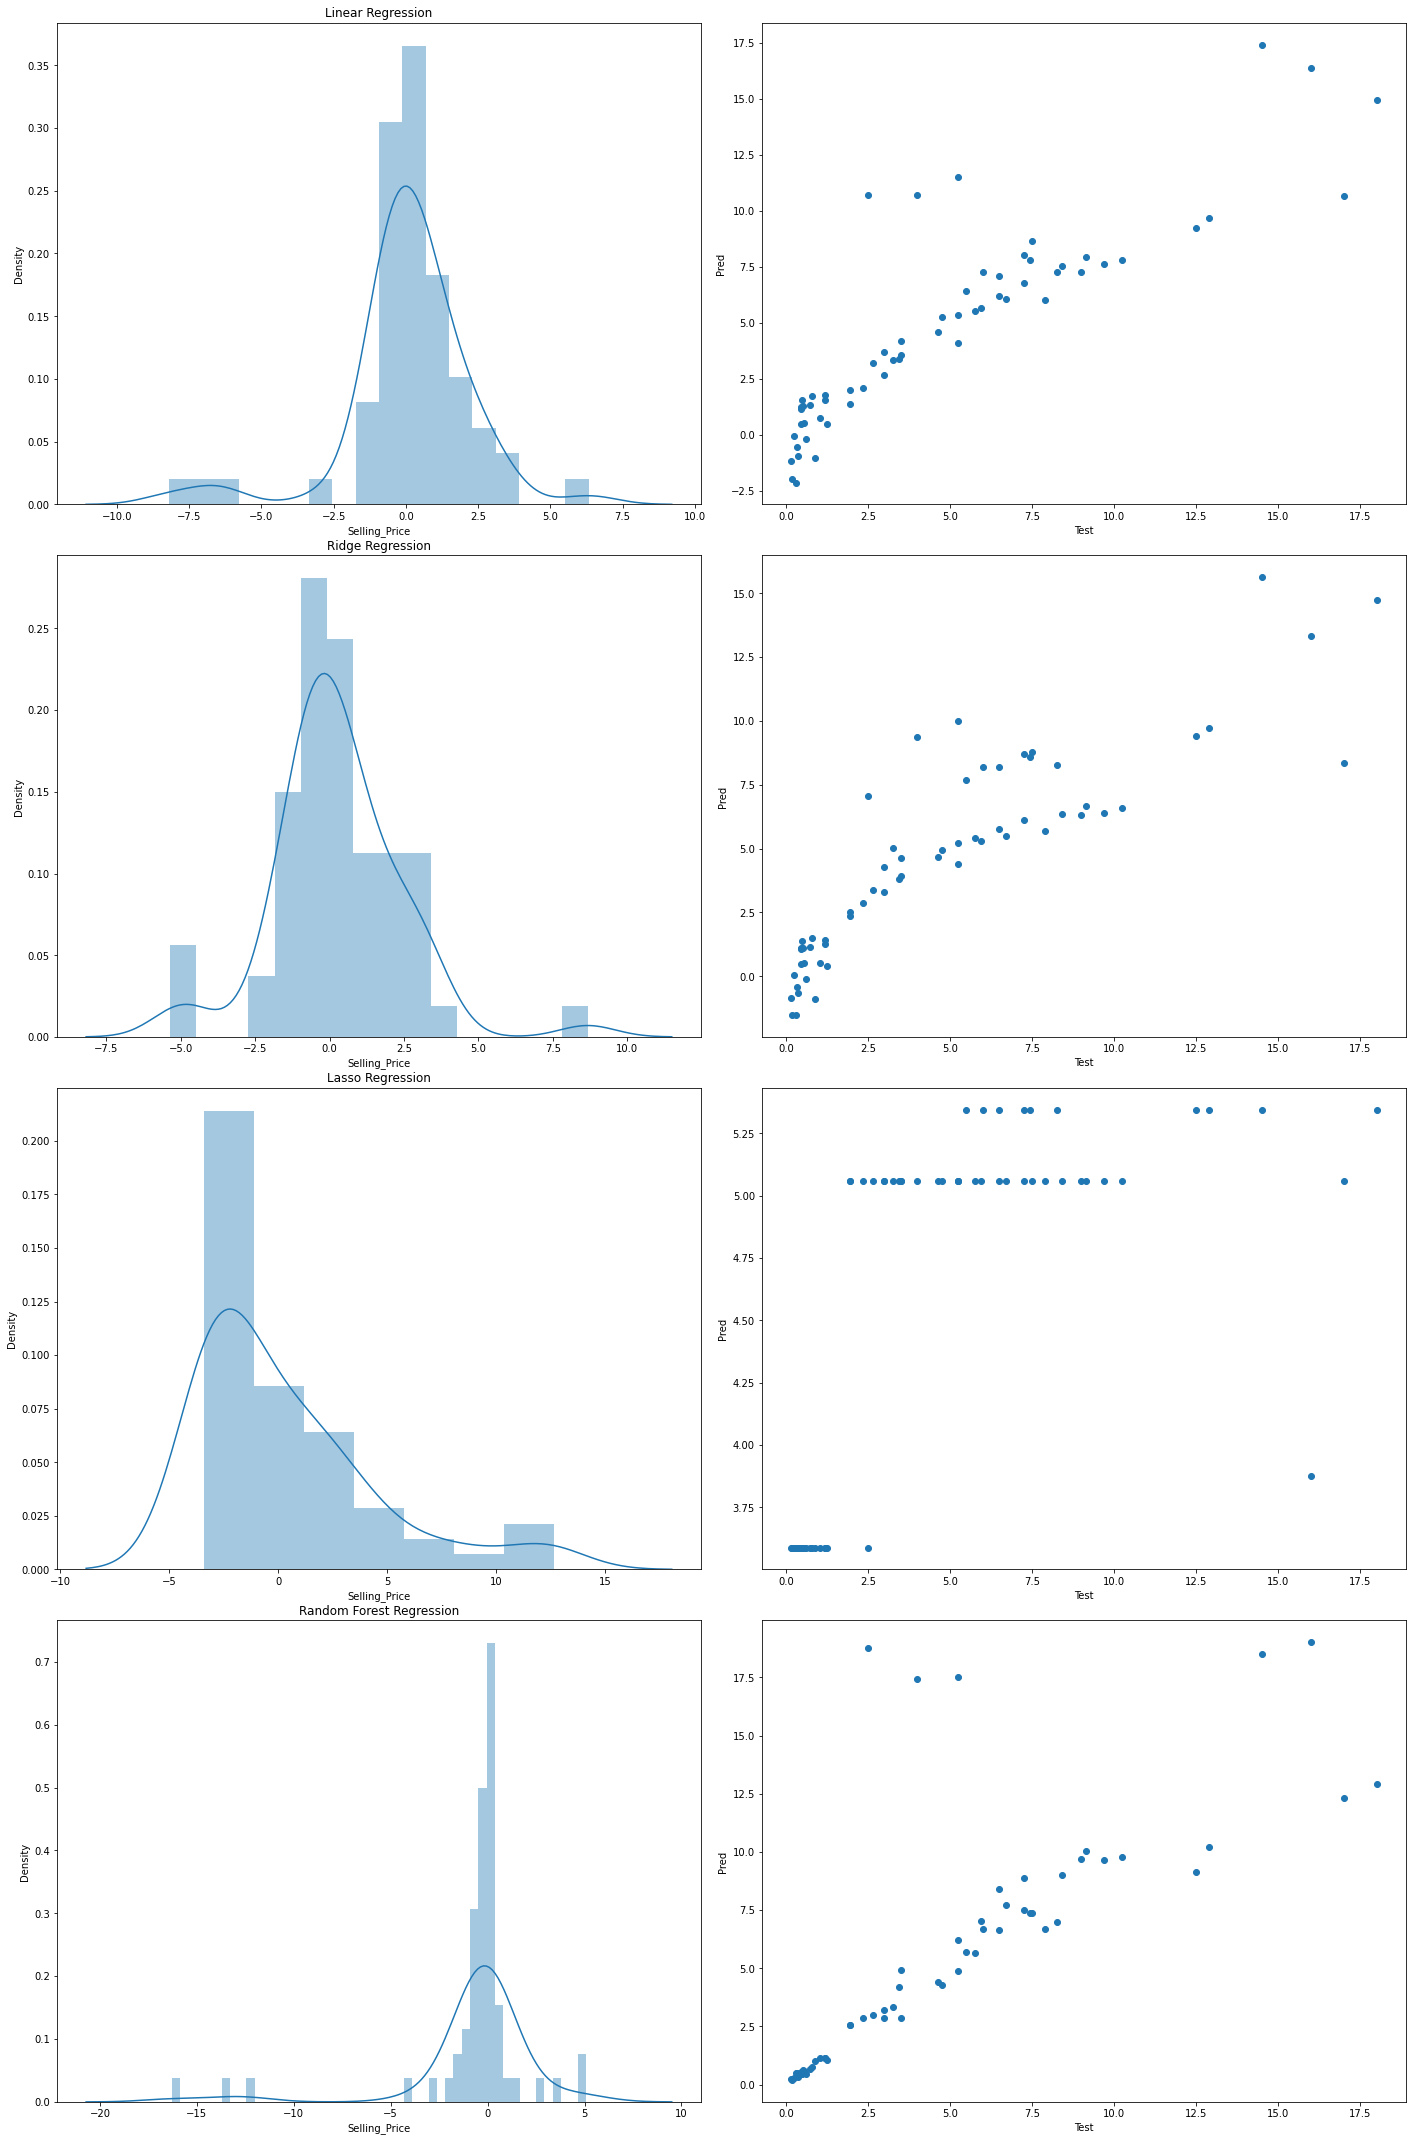

In [43]:
fig,((ax1,ax2),(ax3,ax4),(ax5,ax6),(ax7,ax8)) = plt.subplots(4,2,figsize=(20,30))
fig.tight_layout(pad=3.0)
axs = [[ax1,ax2],[ax3,ax4],[ax5,ax6],[ax7,ax8]]
print('Performing model optimization...')
best_accuracy = -1000000.0
best_reg_idx = 0
best_reg = ''
for idx, rs in enumerate(grids):
    print('\nEstimator: %s' % grid_dict[idx])
    rs.fit(X_train, y_train)
    print('Best params: %s' % rs.best_params_)
    print('Best training accuracy: %.3f' % rs.best_score_)
    y_pred = rs.predict(X_test)
    print('Test set accuracy score for best params: %.3f ' % rs.score(X_test,y_test))
    if rs.score(X_test,y_test) > best_accuracy:
        best_accuracy = rs.score(X_test,y_test)
        best_reg = rs
        best_reg_idx = idx
    
    sns.distplot(y_test-y_pred,ax = axs[idx][0]).set_title(grid_dict[idx])
    axs[idx][1].scatter(y_test,y_pred)
    axs[idx][1].set_xlabel('Test')
    axs[idx][1].set_ylabel('Pred')
print('\nRegressor with best test set accuracy: %s' % grid_dict[best_reg_idx])

In [49]:
# we can conclude that Ridge Regression is giving the best accuracy
file = open('car_price_prediction_model.pkl','wb')
pickle.dump(best_reg,file)